# VARIATIONAL AUTOENCODER EXAMPLE (TENSORFLOW)
In this example we are going to use the MNIST dataset downloaded directly from tensorflow.examples.
First, we specify the different variables:
batch_size: number of instances used in the minibatch gradient descent approximation
X_in: Defining a placeholder for saving the images used in the training examples. The shape is the shape of the tensor
to be fed. None means that it will be the size of the batch. 
Y: This placeholder will hold the images reconstructed by the decoder part of the autoencoder
Y_flat: Y reshaped in order to be used when computing losses
keep_prob: This is used as a placeholder when using the dropout regularization technique
reshaped_dim: dimension of the decoder when sarting the transpose convolutional2D layers after the dense layers
architecture
inputs_decoder: The dimension of the inputs in the decoder phase
The leaky_relu is defined since tensorflow does not have a predefined one (since 1.4.0 release tf.nn.leaky_relu can be used)

The encoder if the first part of the architecture. In this phase, the aim is to find a lower dimensional representation of the images until obtaining the latent variables Z. Firstly, the images are reshaped according to the tensor dimensions:
[batch_size, height, width, channels]. -1 in batch_size means using the batch size defined when splitting the dataset
into batches. RGB for example has 3 channels whereas white and black images have 1 as channels.
The encoder has basically convolutional layers since we are treating with images. However, other types of architectures could be employed instead. 
The mean and standard deviation necessary for the reparametrization trick will be computed using two dense layers which
will be optimized for computing them via the gradients.
The decoder can sample from Q(Z|X) distribution in order to obtain the images back to their real form. Nonetheless, since sampling is stochastic we cannot use backpropagation! To solve this we can apply: z = mean + deviation * epsilon (* meaning elementwise or Hadamard multiplication). This way, all the randomness is saved in the epsilon variables and now
we can use gradients in order to optimize the theta and phi parameters. This is called the reparametrization trick.



In [ ]:
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST", one_hot=False)
print("minist ", mnist.test.labels); exit()
tf.reset_default_graph()
batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name="X")
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name="Y")
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name="keep_prob") #Used for dropout layers
number_of_latent_variables = 20
dec_in_channels = 1
reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2

def leaky_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))


def encoder(X_in, keep_prob):
    
    with tf.variable_scope("encoder", reuse=None):
        X_reshaped = tf.reshape(X_in, shape=[-1, 28, 28, 1]) #reshape where -1 means the batch_size, 
                                                            #28 the height, 28 the width and 1 the number of channels!
        X = tf.layers.conv2d(X_reshaped, filters=64, kernel_size=4, strides=2, padding="same", activation=leaky_relu)
        X = tf.nn.dropout(X, keep_prob)
        X = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding="same", activation=leaky_relu)
        
        X = tf.nn.dropout(X, keep_prob)
        X = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=1, 
                             padding="same", activation=leaky_relu)
        X = tf.nn.dropout(X, keep_prob)
        X = tf.contrib.layers.flatten(X)
        mean = tf.layers.dense(X, units=number_of_latent_variables)
        sd = 0.5 * tf.layers.dense(X, units=number_of_latent_variables)
        epsilon = tf.random_normal([tf.shape(X)[0], number_of_latent_variables])
        z = mean + tf.multiply(epsilon, tf.exp(sd)) #tf.multiply is elementwise or Hadamard multiplication!
        
        return z, mean, sd
    
def decoder(sampled_z, keep_prob):
    
    with tf.variable_scope("decoder", reuse=None):
        X = tf.layers.dense(sampled_z, units=inputs_decoder, activation=leaky_relu)
        X = tf.layers.dense(X, units=inputs_decoder * 2 + 1, activation=leaky_relu)
        X = tf.reshape(X, reshaped_dim)
        X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=2, 
                             padding="same", activation=tf.nn.relu)
        X = tf.nn.dropout(X, keep_prob)
        X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=1, 
                             padding="same", activation=tf.nn.relu)
        X = tf.nn.dropout(X, keep_prob)
        X = tf.layers.conv2d_transpose(X, filters=64, kernel_size=4, strides=1, 
                             padding="same", activation=tf.nn.relu)
        X = tf.contrib.layers.flatten(X)
        X = tf.layers.dense(X, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(X, shape=[-1, 28, 28])
        
        return img

    
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

unreshaped = tf.reshape(dec, [-1, 28 * 28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1) #Log-likelihood 
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1) #Kullback-Leibler divergence
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


iterations = 3000

for i in range(iterations):
    
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    #labels = mnist.train.labels
    labels = mnist.train.next_batch(batch_size=batch_size)[1]
    sess.run(optimizer, feed_dict={X_in: batch, Y: batch, keep_prob: 0.8})
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict={X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap="gray")
        plt.show()
        plt.imshow(d[0], cmap="gray")
        plt.show()
        if number_of_latent_variables == 20:
            coords = sess.run(sampled, feed_dict={X_in: batch, Y: batch, keep_prob: 0.8})
            colormap = ListedColormap(sns.color_palette(sns.hls_palette(10, l=.45, s=.8)).as_hex())
            pca = PCA(n_components=2)
            components = pca.fit_transform(coords)
            plt.scatter(components[:,0], components[:,1], c=labels, cmap=colormap);
            plt.colorbar()
            plt.show()
        


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
('minist ', array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for 

# Gerating new data from distribution Z

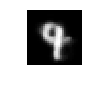

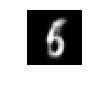

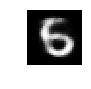

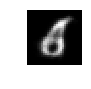

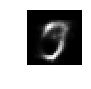

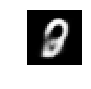

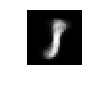

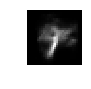

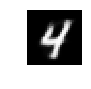

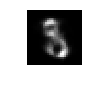

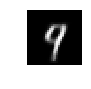

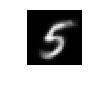

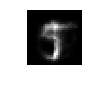

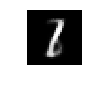

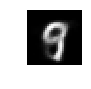

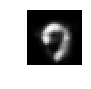

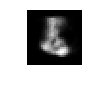

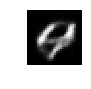

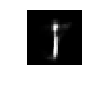

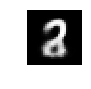

In [2]:
randoms = [np.random.normal(0, 1, number_of_latent_variables) for _ in range(20)]
imgs = sess.run(dec, feed_dict={sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.show()